In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, Conv1D, MaxPooling1D,Flatten
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy, mean_squared_error
from pathlib import Path
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.utils import class_weight
import random

2023-03-07 18:42:38.854924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
import seaborn

In [2]:
data = np.load("./mutations_coverage_prediction.npz")
max_len = 5000
X, Y = data['x'], data['y']

train_x, val_x, train_y, val_y = train_test_split(data['x'], data['y'], test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1)
del X
del Y
del data

print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)
print ('Test:', test_x.shape, test_y.shape)

Training: (72440, 5000, 1) (72440,)
Validation: (8944, 5000, 1) (8944,)
Test: (8049, 5000, 1) (8049,)


In [3]:
# Base model
model = Sequential()
model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=train_x[0].shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1))
model.summary()
adam = Adam(learning_rate=0.00002)
model.compile(optimizer=adam, loss=mean_squared_error)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4998, 128)         512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2499, 128)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 319872)            0         
                                                                 
 dense (Dense)               (None, 1)                 319873    
                                                                 
Total params: 320,385
Trainable params: 320,385
Non-trainable params: 0
_________________________________________________________________


2023-03-07 18:42:46.457306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 18:42:46.477469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 18:42:46.477642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 18:42:46.477981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

In [4]:
es = EarlyStopping(monitor='loss', patience=7)

filepath = 'best_model_cnn_checkpoint.h5'

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

history = model.fit(train_x, train_y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(val_x, val_y),
                    callbacks =[es, checkpoint])

Epoch 1/100


2023-03-07 18:42:48.114386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-07 18:42:48.770608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2264/2264 [==============================] - ETA: 0s - loss: 17.2896
Epoch 1: val_loss improved from inf to 10.66315, saving model to best_model_cnn_checkpoint.h5
2264/2264 [==============================] - 13s 5ms/step - loss: 17.2896 - val_loss: 10.6631
Epoch 2/100
2259/2264 [============================>.] - ETA: 0s - loss: 11.2142
Epoch 2: val_loss improved from 10.66315 to 9.67740, saving model to best_model_cnn_checkpoint.h5
2264/2264 [==============================] - 11s 5ms/step - loss: 11.2074 - val_loss: 9.6774
Epoch 3/100
2264/2264 [==============================] - ETA: 0s - loss: 9.8177
Epoch 3: val_loss did not improve from 9.67740
2264/2264 [==============================] - 11s 5ms/step - loss: 9.8177 - val_loss: 9.8633
Epoch 4/100
2264/2264 [==============================] - ETA: 0s - loss: 10.5184
Epoch 4: val_loss improved from 9.67740 to 9.35617, saving model to best_model_cnn_checkpoint.h5
2264/2264 [==============================] - 11s 5ms/step - loss: 10.5184 

In [5]:
from keras.models import load_model
model.load_weights("best_model_cnn_checkpoint.h5")
test_loss = model.evaluate(test_x, test_y)
test_loss

252/252 [==============================] - 1s 2ms/step - loss: 7.3638


7.363758087158203

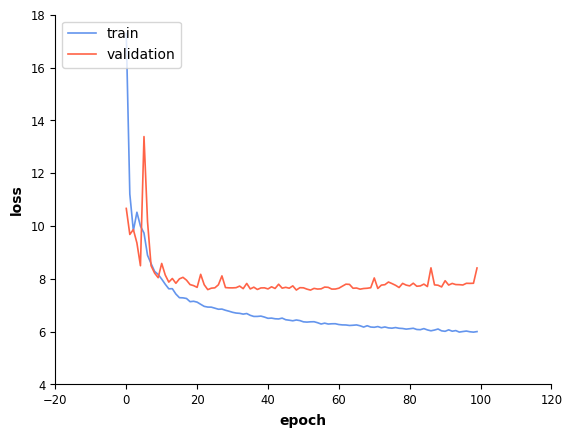

In [33]:
plt.style.use('apa')
# summarize history for loss
plt.plot(history.history['loss'], color='cornflowerblue',alpha=1)
plt.plot(history.history['val_loss'],color='tomato',alpha=1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()